In [1]:
import pandas as pd

file_nws = "/Users/bercinersoz/Desktop/CVI Classifier Project/data/MARKET/datasets CWG - Cash Working Group/CWG_SYR_Dataset_JMMI_Northwest-Syria_Jan_2024_NWS-only.xlsx"
file_nes = "/Users/bercinersoz/Desktop/CVI Classifier Project/data/MARKET/datasets CWG - Cash Working Group/CWG_SYR_Dataset_JMMI_Northeast-Syria_Jan-2024_NES-only.xlsx"

sheets_nws = pd.ExcelFile(file_nws).sheet_names
sheets_nes = pd.ExcelFile(file_nes).sheet_names

print("sheets_nws:", sheets_nws)
print("sheets_nes:", sheets_nes)


sheets_nws: ['ReadmeFirst', 'Summary NWS', 'Sheet1', 'Median_Region', 'Median_Governorate', 'Median_District', 'Median_Subdistrict', 'Median_Community', 'Cleaned _data_NWS', 'Cleaned_data_TRY']
sheets_nes: ['ReadmeFirst', 'Summary NES', 'Region_Medians NES', 'Governorate_Medians', 'District_Medians', 'Subdistrict_Medians', 'Community_Medians', 'Cleaned_Data']


In [2]:
# Load the specific sheets
df_nws = pd.read_excel(file_nws, sheet_name='Median_Community', header=1)
df_nes = pd.read_excel(file_nes, sheet_name='Community_Medians', header=1)


In [3]:
# Filter for the months of 2021, 2022, and 2023 in the 'month2' column
months_to_filter = ['2021', '2022', '2023']

df_nws_filtered = df_nws[df_nws['month2'].str.startswith(tuple(months_to_filter))]
df_nes_filtered = df_nes[df_nes['month2'].str.startswith(tuple(months_to_filter))]

# Select the first 21 columns from both DataFrames
df_nws_filtered = df_nws_filtered.iloc[:, :21]
df_nes_filtered = df_nes_filtered.iloc[:, :21]

# Display the shapes to confirm the operation
print(f"Shape of df_nws_filtered: {df_nws_filtered.shape}")
print(f"Shape of df_nes_filtered: {df_nes_filtered.shape}")


Shape of df_nws_filtered: (2830, 21)
Shape of df_nes_filtered: (1934, 21)


In [5]:
# Check if the column names are the same
same_column_names = df_nws_filtered.columns.tolist() == df_nws_filtered.columns.tolist()

print(f"Do both DataFrames have the same column names? {same_column_names}")

print(df_nws_filtered.columns)
print(df_nes_filtered.columns)

Do both DataFrames have the same column names? True
Index(['month2', 'region', 'q_gov', 'admin1Name_en', 'q_district',
       'admin2Name_en', 'q_sbd', 'admin3Name_en', 'q_town', 'admin4Name_en',
       'smeb_complete', 'smeb_only_missing_water', 'Price_SMEB_total_wfloat',
       'Price_SMEB_total_sanswater', 'Price_smeb_incomplete', 'Price_SMEB_usd',
       'Price_SMEB_food', 'Price_SMEB_nfi', 'Price_SMEB_cookingfuels',
       'Price_SMEB_water', 'Price_SMEB_gbdata'],
      dtype='object')
Index(['month2', 'region', 'q_gov', 'admin1Name_en', 'q_district',
       'admin2Name_en', 'q_sbd', 'admin3Name_en', 'q_town', 'admin4Name_en',
       'smeb_complete', 'smeb_only_missing_water', 'Price_SMEB_total_wfloat',
       'Price_SMEB_total_sanswater', 'Price_smeb_incomplete', 'Price_SMEB_usd',
       'Price_SMEB_food', 'Price_SMEB_nfi', 'Price_SMEB_cookingfuels',
       'Price_SMEB_water', 'Price_SMEB_gbdata'],
      dtype='object')


In [6]:
exchange_rates = pd.read_excel("/Users/bercinersoz/Desktop/exchange_rates.xlsx")

# Ensure 'month2' and 'Date' are datetime
df_nws_filtered['month2'] = pd.to_datetime(df_nws_filtered['month2'])
df_nes_filtered['month2'] = pd.to_datetime(df_nes_filtered['month2'])
exchange_rates['Date'] = pd.to_datetime(exchange_rates['Date'])

# Merge exchange rates with NWS and NES data
df_nws_filtered = df_nws_filtered.merge(exchange_rates[['Date', 'TRY/USD']], 
                                        left_on='month2', right_on='Date', how='left')
df_nes_filtered = df_nes_filtered.merge(exchange_rates[['Date', 'SYP/USD']], 
                                        left_on='month2', right_on='Date', how='left')


In [29]:
df_nws_filtered['TRY/USD'].isna().sum()

0

In [7]:
combined_orginal_data = pd.concat([df_nws_filtered, df_nes_filtered], ignore_index=True)

In [8]:
# Convert NWS data from TRY to USD
columns_to_convert = ['Price_SMEB_total_wfloat', 'Price_SMEB_total_sanswater', 
                      'Price_smeb_incomplete', 'Price_SMEB_food', 'Price_SMEB_nfi',
                      'Price_SMEB_cookingfuels', 'Price_SMEB_water', 'Price_SMEB_gbdata']
for col in columns_to_convert:
    df_nws_filtered[col] = df_nws_filtered[col] * df_nws_filtered['TRY/USD']

# Convert NES data from SYP to USD
for col in columns_to_convert:
    df_nes_filtered[col] = df_nes_filtered[col] * df_nes_filtered['SYP/USD']


In [9]:
combined_df = pd.concat([df_nws_filtered, df_nes_filtered], ignore_index=True)


In [10]:
# Drop the 'Date', 'TRY/USD', and 'SYP/USD' columns from combined_df
columns_to_drop = ['Date', 'TRY/USD', 'SYP/USD']

combined_df = combined_df.drop(columns=columns_to_drop)


In [11]:
# Print the number of rows in each DataFrame before concatenation
print(f"Rows in df_nws_filtered before concatenation: {df_nws_filtered.shape[0]}")
print(f"Rows in df_nes_filtered before concatenation: {df_nes_filtered.shape[0]}")

# Print the number of rows in the combined DataFrame
print(f"Rows in combined DataFrame after concatenation: {combined_df.shape[0]}")


Rows in df_nws_filtered before concatenation: 2830
Rows in df_nes_filtered before concatenation: 1934
Rows in combined DataFrame after concatenation: 4764


In [12]:
# Sort the combined DataFrame by 'month2', 'region', and 'q_town= Community code'
combined_df_sorted = combined_df.sort_values(by=['month2', 'region', 'q_town'])


In [13]:
combined_df_sorted.head()

,month2,region,q_gov,admin1Name_en,q_district,admin2Name_en,q_sbd,admin3Name_en,q_town,admin4Name_en,...,smeb_only_missing_water,Price_SMEB_total_wfloat,Price_SMEB_total_sanswater,Price_smeb_incomplete,Price_SMEB_usd,Price_SMEB_food,Price_SMEB_nfi,Price_SMEB_cookingfuels,Price_SMEB_water,Price_SMEB_gbdata
2830,2021-01-01,northeast,SY02,Aleppo,SY0205,Menbij,SY020500,Menbij,C1679,Farat,...,False,188.689375,183.406825,175.5250,82.685966,149.8628,13.4966,2.50,4.914,4.7516
2831,2021-01-01,northeast,SY02,Aleppo,SY0205,Menbij,SY020500,Menbij,C1767,Menbij,...,False,186.530560,180.919060,173.5168,80.401103,148.2400,13.2152,2.50,5.220,4.3416
2832,2021-01-01,northeast,SY02,Aleppo,SY0205,Menbij,SY020501,Abu Qalqal,C1798,Abu Qalqal,...,False,179.718930,175.249080,167.1804,78.934878,142.4272,13.2700,2.50,4.158,4.8252
2833,2021-01-01,northeast,SY02,Aleppo,SY0206,Ain Al Arab,SY020600,Ain al Arab,C1946,Ain Al Arab,...,False,198.466500,192.661500,184.6200,87.353213,158.6600,13.9200,2.24,5.400,4.4000
2834,2021-01-01,northeast,SY08,Al-Hasakeh,SY0800,Al-Hasakeh,SY080000,Al-Hasakeh,C4351,Tweineh,...,False,232.602480,220.992480,216.3744,102.377852,174.2944,18.8800,10.00,10.800,2.4000


In [14]:
# Calculate the percentage of missing values for each column
missing_percentage = combined_df_sorted.isnull().mean() 

print("Missing value percentages for each column:")
print(missing_percentage)



Missing value percentages for each column:
month2                        0.000000
region                        0.000000
q_gov                         0.000000
admin1Name_en                 0.000000
q_district                    0.000000
admin2Name_en                 0.000000
q_sbd                         0.000000
admin3Name_en                 0.000000
q_town                        0.000000
admin4Name_en                 0.001259
smeb_complete                 0.000000
smeb_only_missing_water       0.000000
Price_SMEB_total_wfloat       0.508186
Price_SMEB_total_sanswater    0.312133
Price_smeb_incomplete         0.000000
Price_SMEB_usd                0.535264
Price_SMEB_food               0.202771
Price_SMEB_nfi                0.147985
Price_SMEB_cookingfuels       0.068220
Price_SMEB_water              0.326616
Price_SMEB_gbdata             0.056885
dtype: float64


In [15]:
# q_town will be used for merging later with HSOS
# Count the number of rows with missing values in q_town
missing_q_town_count = combined_df_sorted['q_town'].isna().sum()
print(f"Number of rows with missing q_town: {missing_q_town_count}")


Number of rows with missing q_town: 0


In [16]:
# Convert True/False to 1/0 for the specified columns
combined_df_sorted['smeb_complete'] = combined_df_sorted['smeb_complete'].astype(int)
combined_df_sorted['smeb_only_missing_water'] = combined_df_sorted['smeb_only_missing_water'].astype(int)

# Print the cleaned DataFrame (optional)
print(combined_df_sorted[['smeb_complete', 'smeb_only_missing_water']].head())


      smeb_complete  smeb_only_missing_water
2830              1                        0
2831              1                        0
2832              1                        0
2833              1                        0
2834              1                        0


In [17]:
# List of categorical columns to exclude
categorical_columns = [
    "month2", "region", "q_gov", "admin1Name_en", "q_district",
    "admin2Name_en", "q_sbd", "admin3Name_en", "q_town", "admin4Name_en", "smeb_complete", "smeb_only_missing_water"
]

# Create a new DataFrame without these categorical columns
df_numerical = combined_df_sorted.drop(columns=categorical_columns, errors="ignore")

# Display the first few rows of the new DataFrame to confirm
df_numerical.info()



<class 'pandas.core.frame.DataFrame'>
Index: 4764 entries, 2830 to 2796
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Price_SMEB_total_wfloat     2343 non-null   float64
 1   Price_SMEB_total_sanswater  3277 non-null   float64
 2   Price_smeb_incomplete       4764 non-null   float64
 3   Price_SMEB_usd              2214 non-null   float64
 4   Price_SMEB_food             3798 non-null   float64
 5   Price_SMEB_nfi              4059 non-null   float64
 6   Price_SMEB_cookingfuels     4439 non-null   float64
 7   Price_SMEB_water            3208 non-null   float64
 8   Price_SMEB_gbdata           4493 non-null   float64
dtypes: float64(9)
memory usage: 372.2 KB


In [18]:
from sklearn.feature_selection import VarianceThreshold

# Apply VarianceThreshold to filter low-variance features
v_threshold = VarianceThreshold(threshold=0.8)  # Set the threshold for variance

# Get the support mask for selected features
support_mask = v_threshold.fit(df_numerical).get_support()

# Filter df_numerical to include only columns with variance above the threshold
df_numerical = df_numerical.iloc[:, support_mask]

print(df_numerical.shape)

#Every column past the threshold.



(4764, 9)


In [19]:
combined_df_sorted.to_excel('/Users/bercinersoz/Desktop/combined_df.xlsx', index=False)

In [20]:
smeb_cost = combined_df_sorted["Price_smeb_incomplete"]
smeb_components = combined_df_sorted[["Price_SMEB_food", "Price_SMEB_nfi", "Price_SMEB_cookingfuels","Price_SMEB_water", "Price_SMEB_gbdata"]]


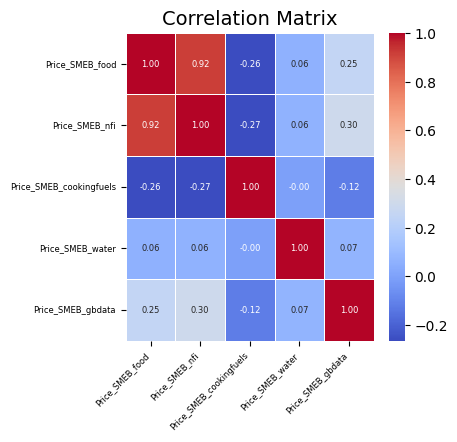

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = smeb_components.corr()

# Heatmap 
plt.figure(figsize=(4,4)) 
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    cbar=True,
    annot_kws={"size": 6}  
)

plt.xticks(rotation=45, ha='right', fontsize=6)  
plt.yticks(fontsize=6)  

plt.title(f"Correlation Matrix", fontsize=14)
plt.show()



In [35]:
# Grouping by month and region and calculating averages
monthly_region_avg = combined_df_sorted.groupby([pd.Grouper(key='month2', freq='M'), 'region'])['Price_smeb_incomplete'].mean().reset_index()

pivot_table = monthly_region_avg.pivot(index='month2', columns='region', values='Price_smeb_incomplete')


print("Pivot table (acc. Month and Region):")
print(pivot_table)


Pivot table (acc. Month and Region):
region       northeast   northwest
month2                            
2021-01-31  200.027787  101.428859
2021-02-28  205.389129  100.793529
2021-03-31  249.246531   98.233399
2021-04-30  126.297887  100.206698
2021-05-31  119.077013   99.362545
2021-06-30  115.088282  101.497209
2021-07-31  121.480987  106.778321
2021-08-31  122.980061  106.011119
2021-09-30  135.987315  107.196130
2021-10-31  140.512545  121.524830
2021-11-30  151.486242   87.998126
2021-12-31  153.190188  121.530419
2022-01-31  156.119405  135.613527
2022-02-28  166.715237  127.071743
2022-03-31  190.499493  133.614124
2022-04-30  204.010100  150.201156
2022-05-31  210.191559  127.429618
2022-06-30  201.259220  132.856357
2022-07-31  191.179651  126.937351
2022-08-31  206.445080  133.913666
2022-09-30  225.911283  133.125099
2022-10-31  240.148876  135.284359
2022-11-30  260.822469  134.100590
2022-12-31  275.409662  140.278145
2023-01-31  287.861687  135.522014
2023-03-31  335.07

/var/folders/rb/r7y3v2dd5234_8hgs73ggvk40000gn/T/ipykernel_30973/1089035365.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month2'] = pd.to_datetime(df['month2'])


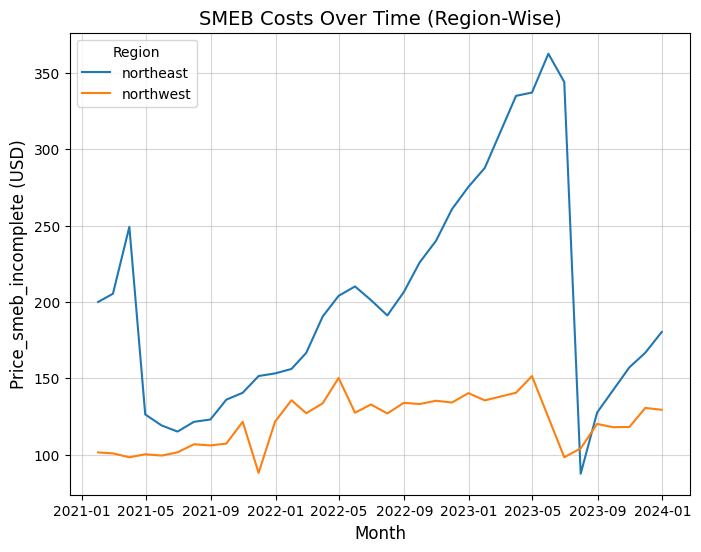

In [48]:
df = combined_df_sorted[['month2', 'region', 'Price_smeb_incomplete', 
                                "Price_SMEB_food", "Price_SMEB_nfi", 
                                "Price_SMEB_cookingfuels", "Price_SMEB_water", "Price_SMEB_gbdata"]]
import matplotlib.pyplot as plt

# Grouping by month and region and calculating averages
df['month2'] = pd.to_datetime(df['month2'])  
monthly_avg = df.groupby([pd.Grouper(key='month2', freq='M'), 'region'])[['Price_smeb_incomplete']].mean().reset_index()


plt.figure(figsize=(8, 6))


for region in monthly_avg['region'].unique():
    regional_data = monthly_avg[monthly_avg['region'] == region]
    plt.plot(regional_data['month2'], regional_data['Price_smeb_incomplete'], label=region)


plt.title("SMEB Costs Over Time (Region-Wise)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Price_smeb_incomplete (USD)", fontsize=12)
plt.legend(title="Region", fontsize=10)
plt.grid(alpha=0.5)

plt.show()



# %80 decrease in exchange rate in 07.2023

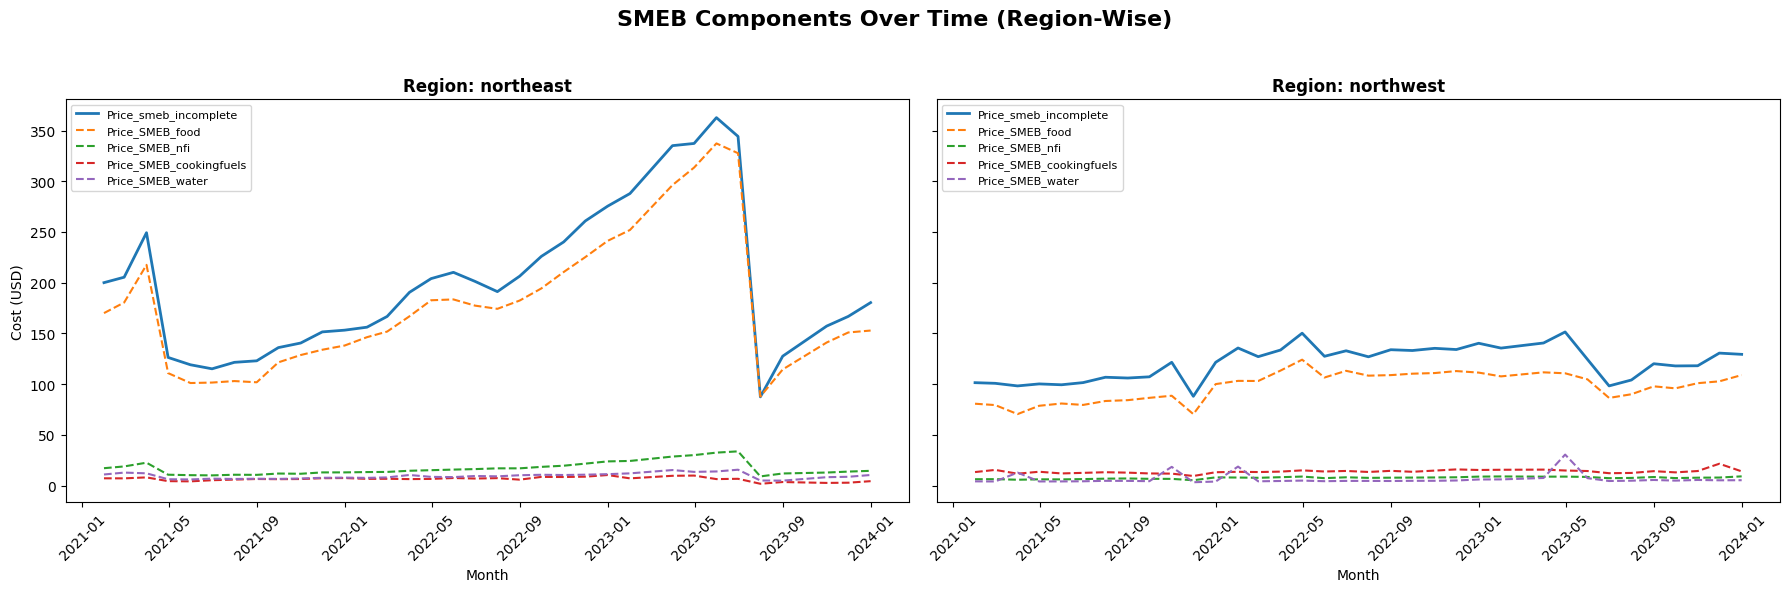

In [47]:
# List of components to plot
components = [
    "Price_smeb_incomplete", 
    "Price_SMEB_food", 
    "Price_SMEB_nfi", 
    "Price_SMEB_cookingfuels", 
    "Price_SMEB_water"
]

# Group data by month and region, and calculate averages
monthly_avg = df.groupby([pd.Grouper(key='month2', freq='M'), 'region'])[components].mean().reset_index()

# Unique regions for subplots
regions = monthly_avg['region'].unique()

# Create subplots for regions
fig, axes = plt.subplots(1, len(regions), figsize=(18, 6), sharey=True)
fig.suptitle("SMEB Components Over Time (Region-Wise)", fontsize=16, weight='bold')

# Iterate over regions to create individual plots
for i, region in enumerate(regions):
    regional_data = monthly_avg[monthly_avg['region'] == region]
    ax = axes[i]

    # Plot 'Price_smeb_incomplete' as a solid line
    ax.plot(regional_data['month2'], regional_data['Price_smeb_incomplete'], label='Price_smeb_incomplete', lw=2)

    # Plot other components as dashed lines
    for component in components[1:]:
        ax.plot(regional_data['month2'], regional_data[component], linestyle='--', label=component)

    # Add titles, labels, and legend
    ax.set_title(f"Region: {region}", fontsize=12, weight='bold')
    ax.set_xlabel("Month", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    if i == 0:  # Add a y-axis label only to the first subplot
        ax.set_ylabel("Cost (USD)", fontsize=10)
    ax.legend(fontsize=8, loc='upper left')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [38]:
july_2023_data_file_path = "/Users/bercinersoz/Desktop/july_2023_data.xlsx"
july_2023_data.to_excel(july_2023_data_file_path, index=False)

print(f"July 2023 data has been saved to: {july_2023_data_file_path}")


July 2023 data has been saved to: /Users/bercinersoz/Desktop/july_2023_data.xlsx


In [39]:
# Norteast 2023-09-01  not exist be carefull in future.
# Filter for rows where the month is September
sept_data = monthly_aggregated[monthly_aggregated['month2'].dt.month == 9]

print("Data for September across all years:")
print(sept_data)


Data for September across all years:
       region     month2  Price_smeb_incomplete  Price_SMEB_food  \
8   northeast 2021-09-01             135.987315       121.458317   
20  northeast 2022-09-01             225.911283       194.331034   
42  northwest 2021-09-01             107.196130        86.484896   
54  northwest 2022-09-01             133.125099       110.288635   
65  northwest 2023-09-01             117.934719        95.839066   

    Price_SMEB_nfi  Price_SMEB_cookingfuels  Price_SMEB_water  \
8        11.856447                 6.293095          6.574500   
20       18.431152                 8.551170         10.630500   
42        6.644117                11.947655          4.324850   
54        7.865989                13.586994          4.678109   
65        7.384105                13.007823          4.880914   

    Price_SMEB_gbdata  
8            1.612287  
20           1.865126  
42           0.263374  
54           0.200099  
65           0.652955  


/var/folders/rb/r7y3v2dd5234_8hgs73ggvk40000gn/T/ipykernel_30973/4150197520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['month2'] = plot_data['month2'].dt.to_period('M')  # Convert to monthly periods


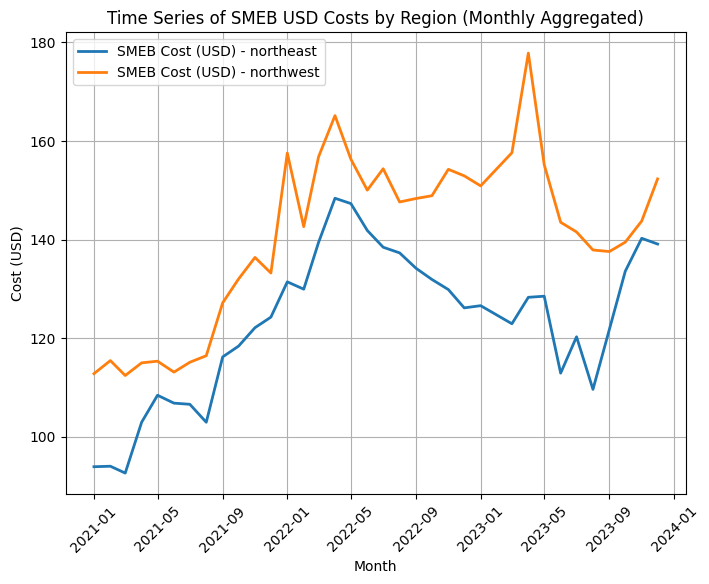

In [49]:

# Filter necessary columns for simplicity
plot_data = combined_df[['month2', 'region', 'Price_SMEB_usd']]

# Aggregate by region and month2 with mean
plot_data['month2'] = plot_data['month2'].dt.to_period('M')  # Convert to monthly periods
monthly_aggregated = plot_data.groupby(['region', 'month2']).mean().reset_index()

# Convert month2 back to datetime for plotting
monthly_aggregated['month2'] = monthly_aggregated['month2'].dt.to_timestamp()

# Plot SMEB USD for each region
plt.figure(figsize=(8, 6))
regions = monthly_aggregated['region'].unique()

for region in regions:
    region_data = monthly_aggregated[monthly_aggregated['region'] == region]
    plt.plot(
        region_data['month2'], 
        region_data['Price_SMEB_usd'], 
        label=f"SMEB Cost (USD) - {region}", 
        linewidth=2
    )

# Add labels, title, and legend
plt.xlabel("Month")
plt.ylabel("Cost (USD)")
plt.title("Time Series of SMEB USD Costs by Region (Monthly Aggregated)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


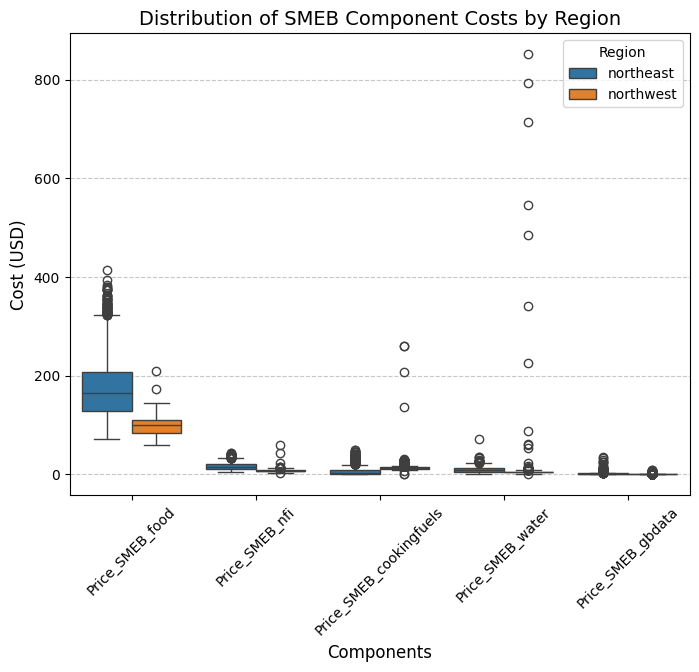

In [50]:
# Melt the dataframe to long format for boxplot compatibility
df_melted = df.melt(id_vars=['region'], 
                    value_vars=["Price_SMEB_food", "Price_SMEB_nfi", 
                                "Price_SMEB_cookingfuels", "Price_SMEB_water", 
                                "Price_SMEB_gbdata"],
                    var_name='Component', 
                    value_name='Cost')

# Create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_melted, x='Component', y='Cost', hue='region')

# Add titles and labels
plt.title("Distribution of SMEB Component Costs by Region", fontsize=14)
plt.ylabel("Cost (USD)", fontsize=12)
plt.xlabel("Components", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.legend(title='Region', fontsize=10)
plt.show()



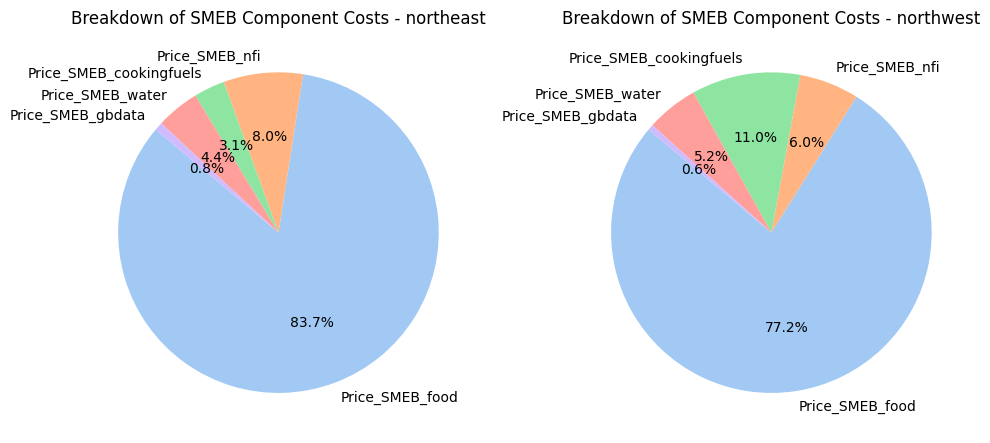

In [51]:
# Pie Chart: Component Breakdown by Region

# Create subplots for the pie charts
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Unique regions
regions = df['region'].unique()

# Columns to include in the pie chart
columns = [ "Price_SMEB_food", "Price_SMEB_nfi", 
           "Price_SMEB_cookingfuels", "Price_SMEB_water", "Price_SMEB_gbdata"]

# Generate pie charts for each region
for i, region in enumerate(regions):
    # Filter and calculate mean for the region
    region_data = df[df['region'] == region][columns].mean()
    
    # Create the pie chart
    axes[i].pie(
        region_data,
        labels=region_data.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("pastel"),
    )
    axes[i].set_title(f"Breakdown of SMEB Component Costs - {region}")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


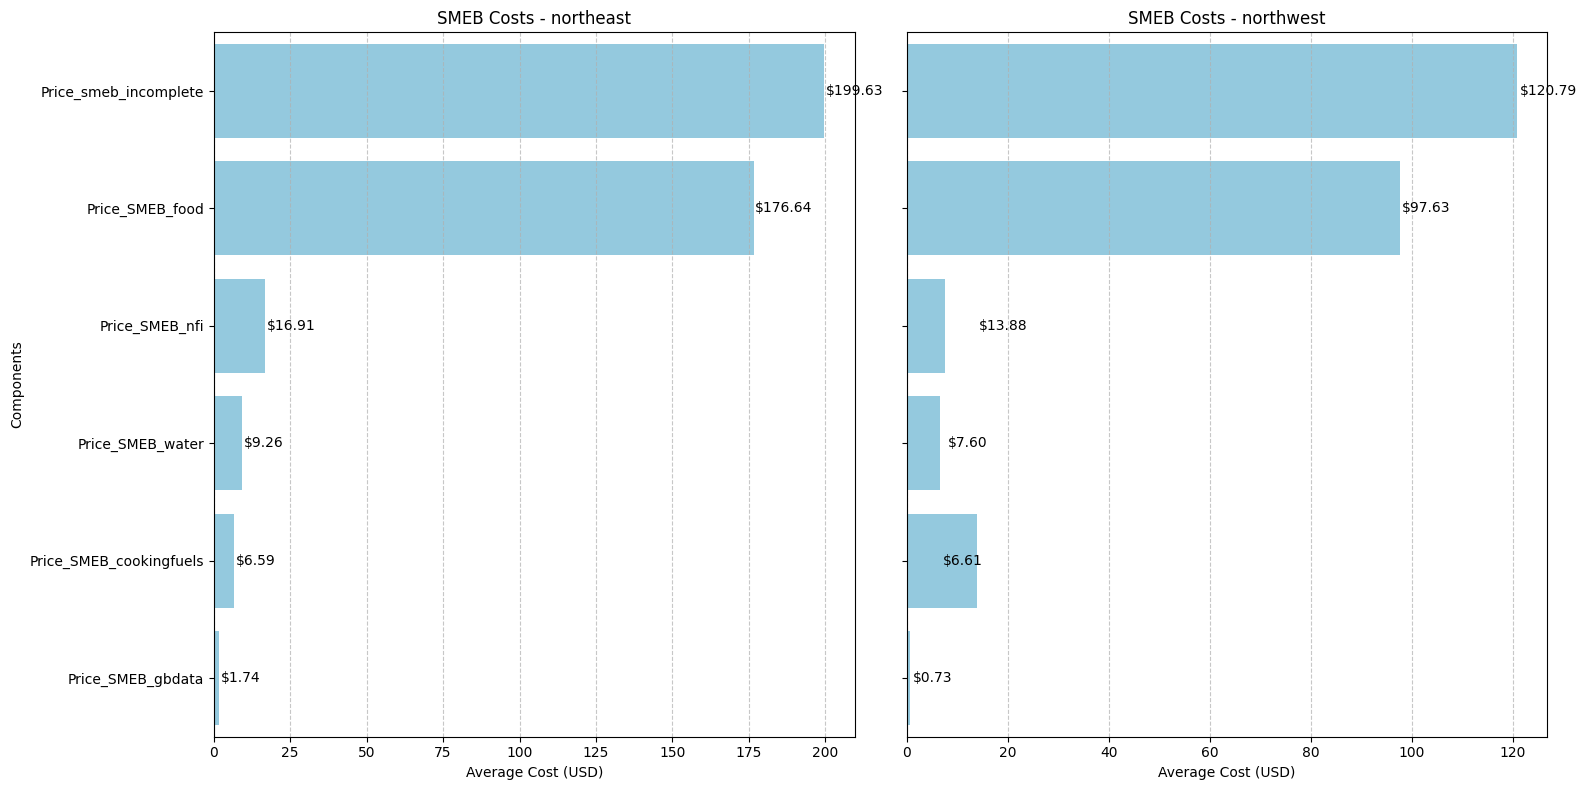

In [43]:
# Horizontal Bar Chart: Cost Ranking by Region

# Define the columns to include in the analysis
columns = ["Price_smeb_incomplete", "Price_SMEB_food", "Price_SMEB_nfi", 
           "Price_SMEB_cookingfuels", "Price_SMEB_water", "Price_SMEB_gbdata"]

# Calculate the mean of SMEB components by region
smeb_means_by_region = df.groupby('region')[columns].mean()

# Create subplots for each region
fig, axes = plt.subplots(1, len(smeb_means_by_region.index), figsize=(16, 8), sharey=True)

# Loop through regions to create separate plots
for i, region in enumerate(smeb_means_by_region.index):
    region_data = smeb_means_by_region.loc[region].sort_values(ascending=False)
    sns.barplot(x=region_data, y=region_data.index, orient='h', ax=axes[i], color="skyblue")
    axes[i].set_title(f"SMEB Costs - {region}")
    axes[i].set_xlabel("Average Cost (USD)")
    if i == 0:
        axes[i].set_ylabel("Components")
    else:
        axes[i].set_ylabel("")
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add labels on bars
    for index, value in enumerate(region_data):
        axes[i].text(value + 0.5, index, f"${value:.2f}", va='center', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


